In [30]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import numpy as np
import scipy.linalg
from astropy import units as u
from astropy.visualization import quantity_support
from matplotlib import pyplot as plt
from astropy import constants as const
#from baseband_tasks.io import hdf5
from astropy.time import Time
import pickle
from scipy.optimize import curve_fit
from scipy.sparse.linalg import eigsh
from matplotlib.colors import LogNorm
from glob import glob

In [32]:
import sys
import ththmod as THTH
import load_data as ld
import ds_psr as dsa
import fit_thth as fth
import models_thth as mth

import sys
sys.path.append('/home/gusinskaia/screens')
#from screens.fields import dynamic_field, theta_grid
from screens.dynspec import DynamicSpectrum
from screens.visualization import ThetaTheta
from screens.fields import dynamic_field, theta_grid, theta_theta_indices

In [33]:
trdir='/mnt/scratch-lustre/gusinskaia/triple_system/'
odir=trdir+'dss_mean/'
fitdir=trdir+'for_fit/'
npydir=trdir+'npys_vels/'
imdir=trdir+'fitted_figures/'
vlbidir=trdir+'dss_realvlba/'
longdir=trdir+'dss_long/'
onetotwo_dir=trdir+'dss_1to2/'
armdir=trdir+'one_armed_arc/'
nsdir=trdir+'dss_wsrt_wnoise/'

spec_pieces=np.array([[1301,1317],[1321,1337],[1341,1357],[1361,1377],[1381,1397],
                      [1401,1417],[1421,1437],[1441,1457]])

In [49]:
list_data=sorted(glob(nsdir+'*wns.npz'))
print (len(list_data))
for i in range(0,len(list_data)):
    print (i, list_data[i][-28:])

13
0 se/5607130_WSRT_1400_wns.npz
1 se/5607431_WSRT_1400_wns.npz
2 se/5608723_WSRT_1400_wns.npz
3 se/5608733_WSRT_1400_wns.npz
4 se/5609121_WSRT_1400_wns.npz
5 se/5609135_WSRT_1400_wns.npz
6 se/5609846_WSRT_1400_wns.npz
7 se/5609859_WSRT_1400_wns.npz
8 se/5610532_WSRT_1400_wns.npz
9 se/5610541_WSRT_1400_wns.npz
10 se/5610618_WSRT_1400_wns.npz
11 se/5611021_WSRT_1400_wns.npz
12 se/5611031_WSRT_1400_wns.npz


In [50]:
k=0
sp=dsa.load_triple_spectrum(list_data[k], wnoise=True, mean0=True)


sp_shr=dsa.load_triple_spectrum(list_data[k], factor=[16,1], wnoise=True, mean0=True)
sp

(1439, 512)
(1439, 512)
(1439, 512)
(1439, 512)
(89, 512)
(89, 512)


<Dynamic spectrum: Dur: 4.00 hr, Freq: 1300.00 - 1460 MHz, MJD: 56071.30, PSR: PSRJ0337+1715, Tel: WSRT, w noise>

# Full dynamic spectrum


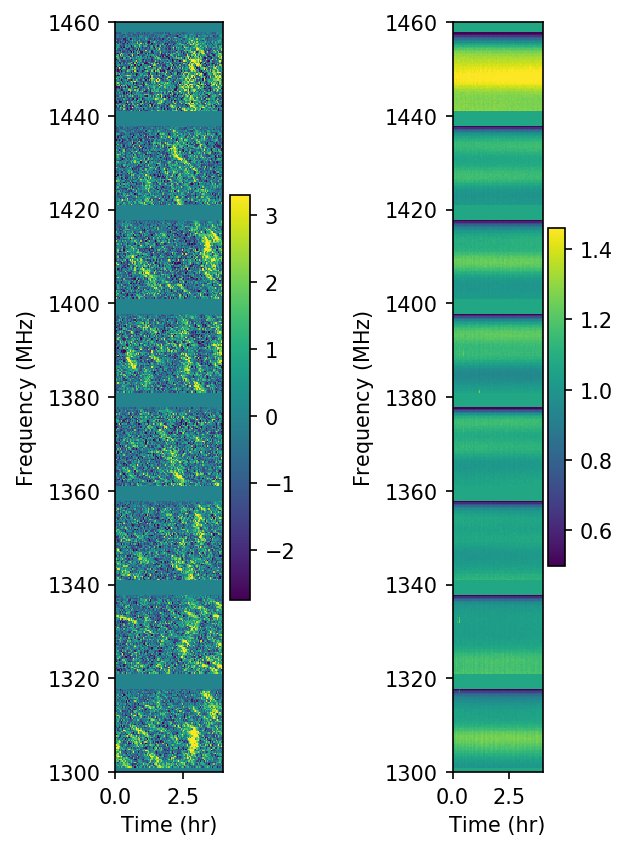

In [51]:
fig=plt.figure(figsize=(3,5), dpi=150)
fig.add_axes([0.0,0.0,0.3,1])
plt.gca()
sp_shr.plot_ds(new_fig=False)
plt.colorbar()
fig.add_axes([0.75,0.0,0.25,1])
plt.gca()
sp_shr.plot_nds(new_fig=False)
plt.colorbar()

In [37]:
np.array([3.5,7.6], dtype=int)

array([3, 7])

In [38]:
new_sp=sp.shrink(factor=[4,7])

(359, 73)
(359, 73)


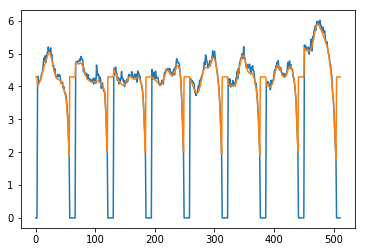

In [39]:
plt.plot(np.std(sp_shr.I, axis=0))
plt.plot(np.mean(sp_shr.nI, axis=0))

In [53]:
print (np.std(sp_shr.I), np.mean(sp_shr.nI))

1.18503108626 1.07237565621


In [54]:
i=1
sp_sel=sp.select(time_sel=[sp.stend[0]*u.d,sp.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])

sp_shr_sel=sp_shr.select(time_sel=[sp_shr.stend[0]*u.d,sp_shr.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])
sp_sel

<Dynamic spectrum: Dur: 4.00 hr, Freq: 1320.98 - 1337 MHz, MJD: 56071.30, PSR: PSRJ0337+1715, Tel: WSRT, w noise>

## Part of DS that is going to be used as an example: 
(very bad quality, but still works)

Scranched shape: (89, 52)
Original shape: (1439, 52)


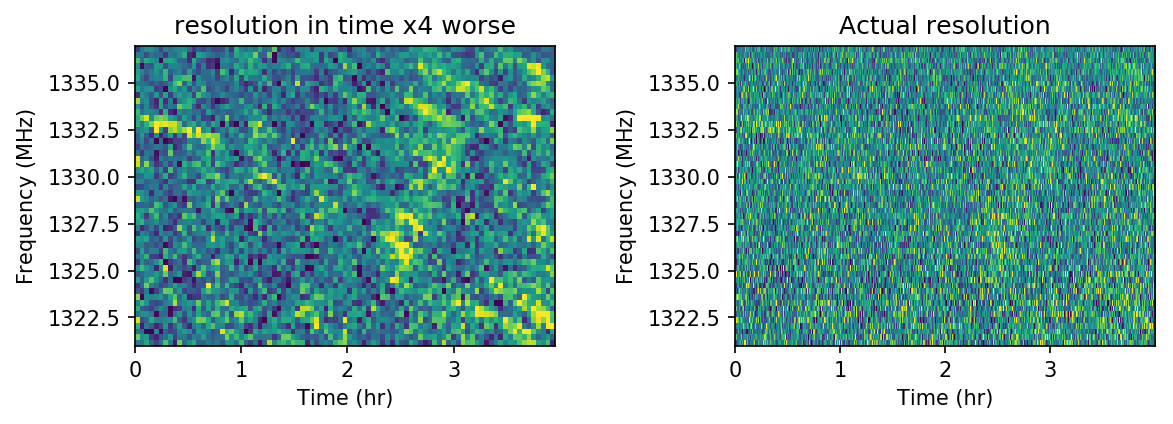

In [55]:
fig=plt.figure(figsize=(8,2), dpi=150)
fig.add_axes([0.0,0.0,0.35,1.0])
frame1=plt.gca()
sp_shr_sel.plot_ds(new_fig=False)
plt.title('resolution in time x4 worse')
print ('Scranched shape:', np.shape(sp_shr_sel.I))

fig.add_axes([0.5,0.0,0.35,1.0])
frame1=plt.gca()
sp_sel.plot_ds(new_fig=False)
plt.title('Actual resolution')
print ('Original shape:', np.shape(sp_sel.I))




# Make secondary spectrum  $\tilde{I}\left( f_D,\tau \right)$:


Original shape: (52, 1439)
Padded shape: (208, 5756)


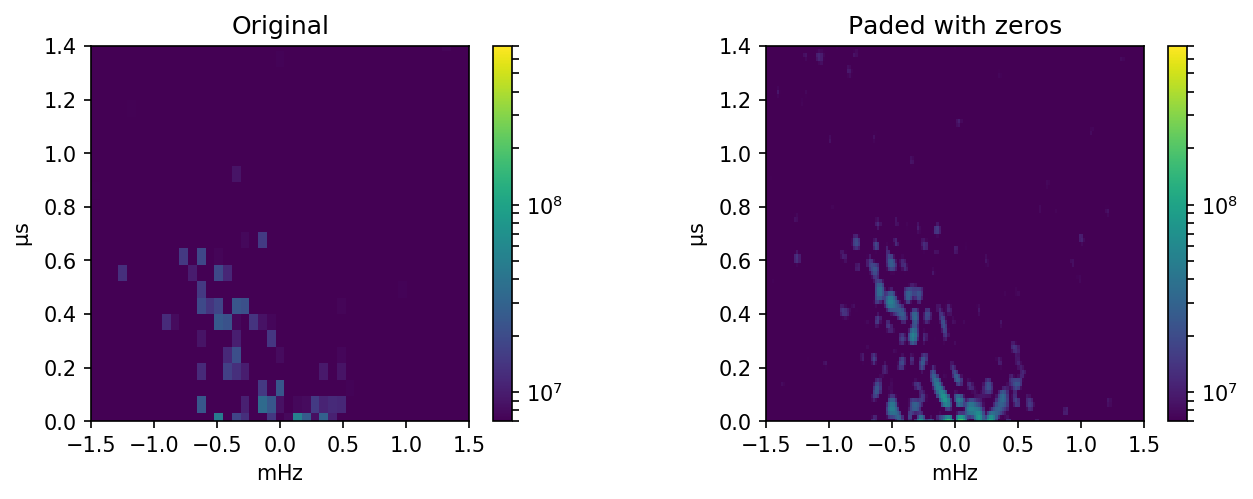

In [56]:
fig=plt.figure(figsize=(9,2.5), dpi=150)
fig.add_axes([0.0,0.0,0.35,1.0])
frame1=plt.gca()
sp_sel.ss=sp_sel.make_ss(pad_it=False)
sp_sel.plot_ss(new_fig=False, vmin=7e6, vmax=7e8)
plt.title('Original')
print ('Original shape:', np.shape(sp_sel.ss.Is))

fig.add_axes([0.5,0.0,0.35,1.0])
frame1=plt.gca()
sp_sel.ss=sp_sel.make_ss(pad_it=True, npad=3)
sp_sel.plot_ss(new_fig=False, vmin=7e6, vmax=7e8)
plt.title('Paded with zeros')
print ('Padded shape:', np.shape(sp_sel.ss.Is))


# Map $\theta - \theta$ space

# Daniel Approach:
## $$\tilde{I}\left(\theta_1,\theta_2;\eta\right) = \tilde{I}\left( f_D\left(\theta_1,\theta_2\right),
                                                                \tau\left(\theta_1,\theta_2;
                                                                          \eta\right)\right)
\sqrt{|2\eta\left(\theta_1-\theta_2\right)|}$$

## For  $\eta = 1.3 s^3$

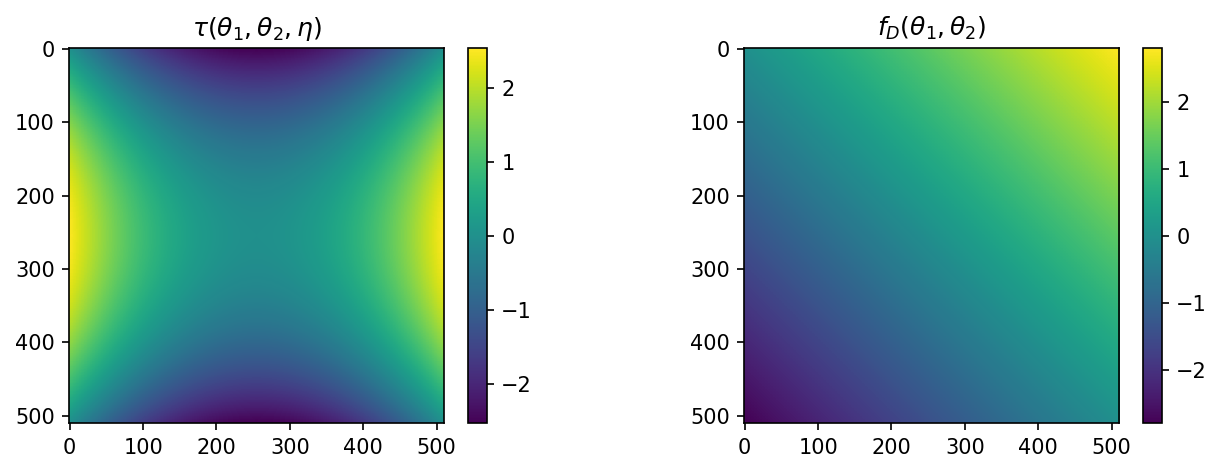

In [57]:
edge, ntau=1.4, 512
edges=np.linspace(-edge,edge,ntau)
th_cents = (edges[1:] + edges[:-1]) / 2
th_cents -= th_cents[np.abs(th_cents) == np.abs(th_cents).min()]
# Calculate theta1 and th2 arrays
th1 = np.ones((th_cents.shape[0], th_cents.shape[0])) * th_cents
th2 = th1.T
fig=plt.figure(figsize=(9,2.5), dpi=150)
fig.add_axes([0.0,0.0,0.35,1.0])
frame1=plt.gca()
plt.imshow((th1**2-th2**2)*1.3)
plt.colorbar()
plt.title(r'$\tau (\theta_1, \theta_2, \eta)$')

fig.add_axes([0.5,0.0,0.35,1.0])
frame1=plt.gca()
plt.imshow(th1-th2)
plt.colorbar()
plt.title(r'$f_D (\theta_1, \theta_2)$')

## $$  f_D = \theta_1 - \theta_2$$

## $$\tau = \eta \left(\theta_1^2 - \theta_2^2\right) = \eta  f_D(\theta_1+\theta_2)$$

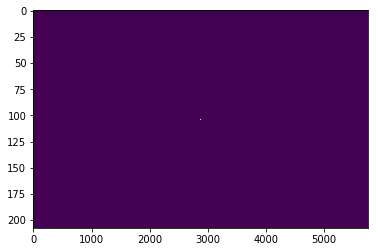

In [64]:
ss=np.abs(np.abs(sp_sel.ss.Is)**2)

sp_sel.ss.tau

plt.imshow(ss, aspect='auto')

In [65]:
sp_sel.ss.tau.shape

(208,)

In [59]:
sp_sel.ss.Is.shape

(208, 5756)

In [95]:
sp_sel.ss.Is.size

1197248

In [93]:
sp_sel.I.shape

(1439, 52)

In [ ]:
ndof=ds.shape[1]*ds.shape[0]-thth_red.shape[0] - 2

In [99]:
sp_sel.ss.tau.shape

(208,)

In [104]:
(208-73)+2

137

In [101]:
tau_r.shape[0]

183

In [96]:
thth_r.size

261121

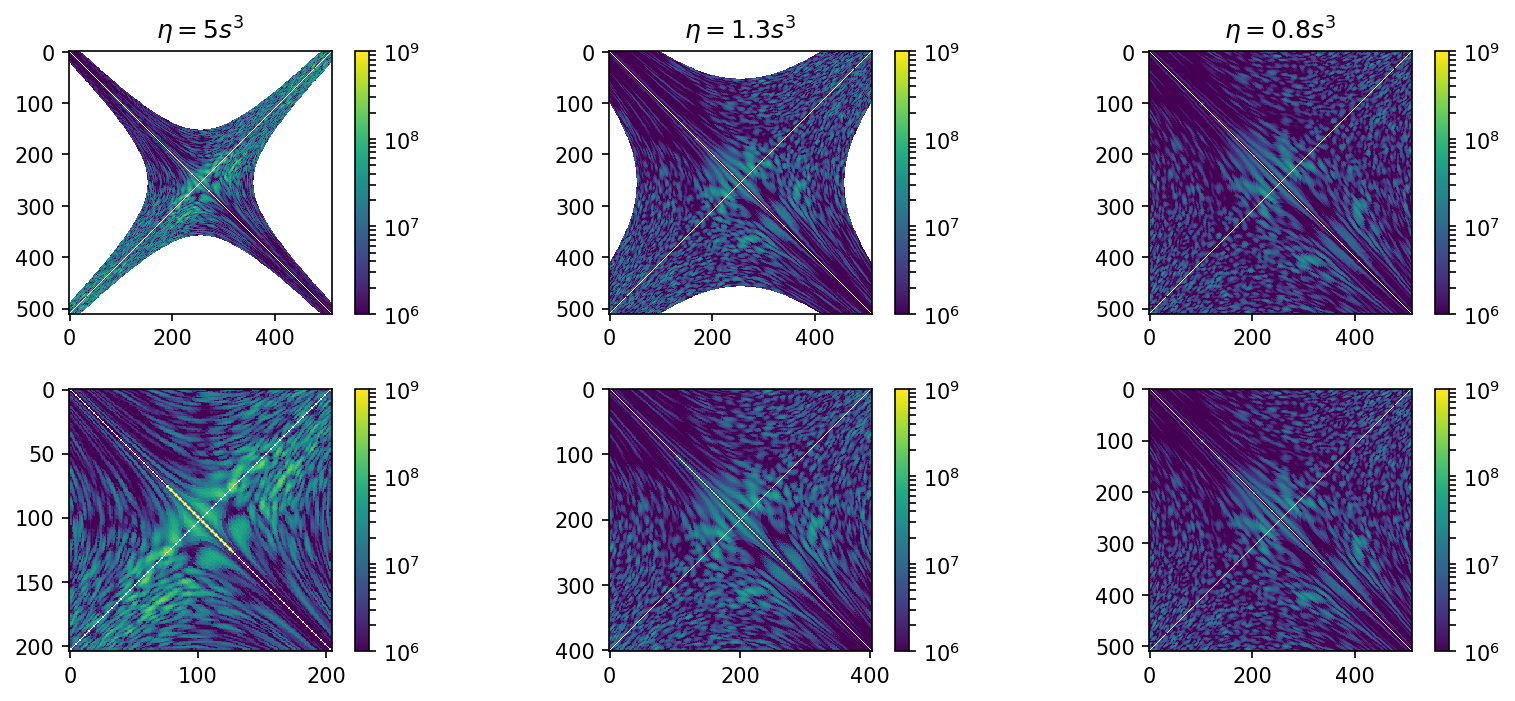

In [66]:
edge, ntau=1.4, 512
edges=np.linspace(-edge,edge,ntau)
vmin, vmax=1e6, 1e9

fig=plt.figure(figsize=(9,5), dpi=150)

fig.add_axes([0.0,0.0,0.35,0.35])
frame1=plt.gca()
thth=THTH.thth_map(sp_sel.ss.Is,sp_sel.ss.tau,sp_sel.ss.fd,eta=5*u.us/(u.mHz**2),edges=edges)
plt.imshow(abs(thth)**2,norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.title(r'$\eta= 5 s^3$')

fig.add_axes([0.0,-0.45,0.35,0.35])
frame1=plt.gca()
thth_r, edges_r=THTH.thth_redmap(sp_sel.ss.Is,sp_sel.ss.tau,sp_sel.ss.fd,eta=5*u.us/(u.mHz**2),edges=edges)
plt.imshow(abs(thth_r)**2,norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()

fig.add_axes([0.4,0.0,0.35,0.35])
frame1=plt.gca()
thth=THTH.thth_map(sp_sel.ss.Is,sp_sel.ss.tau,sp_sel.ss.fd,eta=1.3*u.us/(u.mHz**2),edges=edges)
plt.imshow(abs(thth)**2,norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.title(r'$\eta= 1.3 s^3$')

fig.add_axes([0.4,-0.45,0.35,0.35])
frame1=plt.gca()
thth_r, edges_r=THTH.thth_redmap(sp_sel.ss.Is,sp_sel.ss.tau,sp_sel.ss.fd,eta=1.3*u.us/(u.mHz**2),edges=edges)
plt.imshow(abs(thth_r)**2,norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()

fig.add_axes([0.8,0.0,0.35,0.35])
frame1=plt.gca()
thth=THTH.thth_map(sp_sel.ss.Is,sp_sel.ss.tau,sp_sel.ss.fd,eta=0.8*u.us/(u.mHz**2),edges=edges)
plt.imshow(abs(thth)**2,norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.title(r'$\eta= 0.8 s^3$')
fig.add_axes([0.8,-0.45,0.35,0.35])
frame1=plt.gca()
thth_r, edges_r=THTH.thth_redmap(sp_sel.ss.Is,sp_sel.ss.tau,sp_sel.ss.fd,eta=0.8*u.us/(u.mHz**2),edges=edges)
plt.imshow(abs(thth_r)**2,norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()

In [67]:
fitdic, fit_freq, fit_time, res_dic=fth.daniel_pars_fit(sp_sel, curv_par='eta', etas_pars=[0.25,5.5,0.25])

fit: <Dynamic spectrum: Dur: 4.00 hr, Freq: 1320.98 - 1337 MHz, MJD: 56071.30, PSR: PSRJ0337+1715, Tel: WSRT, w noise>


In [ ]:
mE, mI, mI=flip(model_field, axis=1), chi2

In [91]:
print (np.amin(edges_r), np.amax(edges_r))
print (np.shape(thth_r))
np.ptp(edges_r)

-1.4 1.4
(511, 511)


2.7999999999999998

In [87]:
tau_r=sp_sel.ss.tau[(sp_sel.ss.tau.value>np.amin(edges_r)) & (sp_sel.ss.tau.value<np.amax(edges_r))]
tau_r.shape

(183,)

In [92]:
print (np.amin(sp_sel.ss.tau), np.amax(sp_sel.ss.tau))

-1.5968750000000453 us 1.5815204326923527 us


In [83]:
eta=fitdic['eta']
eta=0.8*u.us/(u.mHz**2)
eta

<Quantity 0.8 us / mHz2>

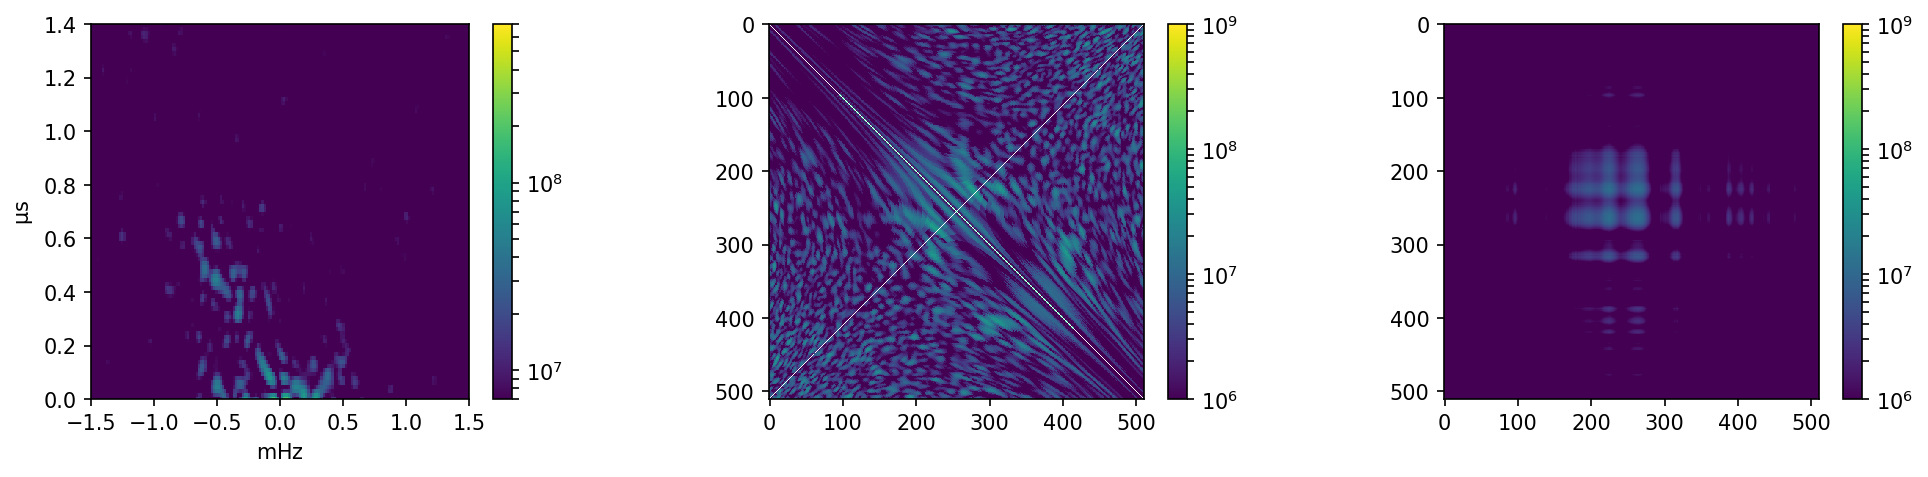

In [84]:
thth_r, edges_r=THTH.thth_redmap(sp_sel.ss.Is,sp_sel.ss.tau,sp_sel.ss.fd,eta=eta,edges=edges)
w, V = eigsh(thth_r,1,which='LA')
thth2_red=np.outer(V,np.conjugate(V))
thth2_red*=np.abs(w)
fig=plt.figure(figsize=(9,2.5), dpi=150)
fig.add_axes([-0.5,0.0,0.35,1.0])
frame1=plt.gca()
sp_sel.ss=sp_sel.make_ss(pad_it=True, npad=3)
sp_sel.plot_ss(new_fig=False, vmin=7e6, vmax=7e8)

fig.add_axes([0.0,0.0,0.35,1.0])
frame1=plt.gca()
plt.imshow(abs(thth_r)**2,norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()

fig.add_axes([0.5,0.0,0.35,1.0])
frame1=plt.gca()
plt.imshow(abs(thth2_red)**2,norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.savefig('daniels_thth_mapping.png',format='png', bbox_inches='tight',dpi=150)

In [78]:
tau, fd=sp_sel.ss.tau,sp_sel.ss.fd
# Find bin centers
th_cents = (edges_r[1:] + edges_r[:-1]) / 2
th_cents -= th_cents[np.abs(th_cents) == np.abs(th_cents).min()]

fd_map=(th_cents[np.newaxis,:]-th_cents[:,np.newaxis])
tau_map=eta.value*(th_cents[np.newaxis,:]**2-th_cents[:,np.newaxis]**2)

fd_edges=(np.linspace(0,fd.shape[0],fd.shape[0]+1)-.5)*(fd[1]-fd[0]).value+fd[0].value
tau_edges=(np.linspace(0,tau.shape[0],tau.shape[0]+1)-.5)*(tau[1]-tau[0]).value+tau[0].value
    
recov=np.histogram2d(np.ravel(fd_map),np.ravel(tau_map),bins=(fd_edges,tau_edges),
                     weights=np.ravel(thth2_red/np.sqrt(np.abs(2*eta*fd_map.T).value)).real)[0] +\
        np.histogram2d(np.ravel(fd_map),np.ravel(tau_map),bins=(fd_edges,tau_edges),
                     weights=np.ravel(thth2_red/np.sqrt(np.abs(2*eta*fd_map.T).value)).imag)[0]*1j
norm=np.histogram2d(np.ravel(fd_map),np.ravel(tau_map),bins=(fd_edges,tau_edges))[0]

recov += np.histogram2d(np.ravel(-fd_map),np.ravel(-tau_map),bins=(fd_edges,tau_edges),
                    weights=np.ravel(thth2_red/np.sqrt(np.abs(2*eta*fd_map.T).value)).real)[0] -\
        np.histogram2d(np.ravel(-fd_map),np.ravel(-tau_map),bins=(fd_edges,tau_edges),
                    weights=np.ravel(thth2_red/np.sqrt(np.abs(2*eta*fd_map.T).value)).imag)[0]*1j
norm+=np.histogram2d(np.ravel(-fd_map),np.ravel(-tau_map),bins=(fd_edges,tau_edges))[0] 
recov/=norm
recov=np.nan_to_num(recov)

np.shape(recov)



(5756, 208)

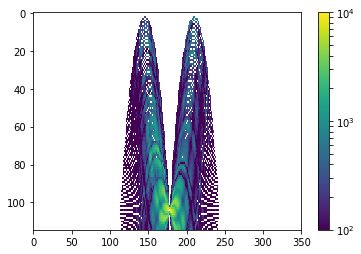

In [79]:
plt.imshow(np.abs(recov)[2700:3050,0:115].T, aspect='auto',norm=LogNorm(), vmin=1e2, vmax=1e4)
plt.colorbar()

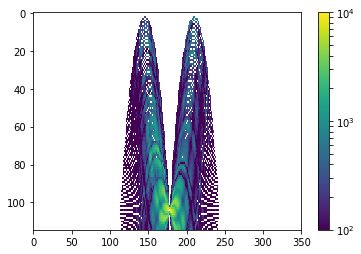

In [80]:
plt.imshow(np.abs(recov)[2700:3050,0:115].T, aspect='auto',norm=LogNorm(), vmin=1e2, vmax=1e4)
plt.colorbar()

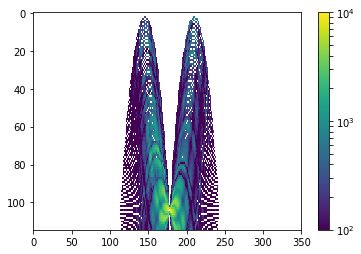

In [81]:
plt.imshow(np.abs(recov)[2700:3050,0:115].T, aspect='auto',norm=LogNorm(), vmin=1e2, vmax=1e4)
plt.colorbar()

# Marten apprpach

In [189]:
spec=spec_sel
s=0.5
d_psr=1.3*u.kpc

c=const.c
d_eff=((1.-s)/s)*d_psr
mu_eff=dsa.eta_to_mu(1.3*u.us/(u.mHz**2), spec, d_eff)
fobs=np.mean(spec.f)

dynspec=spec.I
t=spec.t[:, np.newaxis]
f=spec.f

ss, tau, fd=dsa.mrt_ss(dynspec, f, t)

1.0645833333333636 us


(-0.2, 1.5)

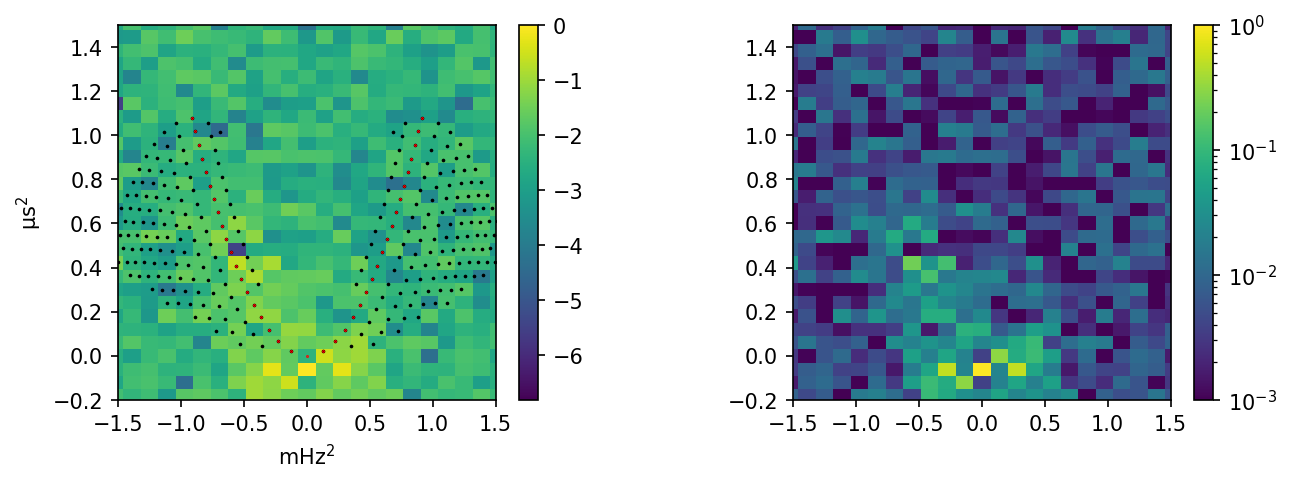

In [225]:
tau_max = (1./(f[3]-f[0])).to(u.us)
print (tau_max)
th_g = theta_grid(d_eff, mu_eff, fobs=fobs,
                  dtau=1/f.ptp(), tau_max=tau_max,
                  dfd=1/t.ptp(), fd_max=1*u.Hz)
fd_g = (d_eff/const.c*mu_eff*fobs*th_g).to(
    u.mHz, equivalencies=u.dimensionless_angles())
tau_g = (d_eff/(2*const.c)*th_g**2).to(
    u.us, equivalencies=u.dimensionless_angles())

i0, i1 = theta_theta_indices(th_g)

fig=plt.figure(figsize=(9,2.5), dpi=150)
fig.add_axes([0.0,0.0,0.35,1.0])
frame1=plt.gca()
plt.plot(fd_g[i0]-fd_g[i1], tau_g[i0]-tau_g[i1], 'ko', ms=0.75)
plt.plot(fd_g, tau_g, 'ro', ms=0.4)
sec_extent = (fd[0].value, fd[-1].value, tau[0].value, tau[-1].value)
plt.imshow(np.log10(ss.T), aspect='auto', extent=sec_extent,cmap='viridis')
plt.xlabel(fd.unit.to_string('latex'))
plt.ylabel(tau.unit.to_string('latex'))
plt.xlim(-1.5, 1.5)
plt.ylim(-0.2,1.5)
plt.colorbar()

fig.add_axes([0.5,0.0,0.35,1.0])
frame1=plt.gca()
plt.imshow(ss.T,norm=LogNorm(vmin=1e-3, vmax=1e0),aspect='auto',extent=sec_extent)
plt.colorbar()
plt.xlim(-1.5, 1.5)
plt.ylim(-0.2,1.5)

### Samples vector of thetas and transforms it to $\tau$ and $f_D$:

## $$\tau \left(\bar{\theta}\right) =\frac{\bar{\theta}^2 d_{\text{eff}}}{2c}$$

## $$f_D\left(\bar{\theta}\right) =  \frac{v_{\parallel} \bar{\theta}}{\lambda}$$

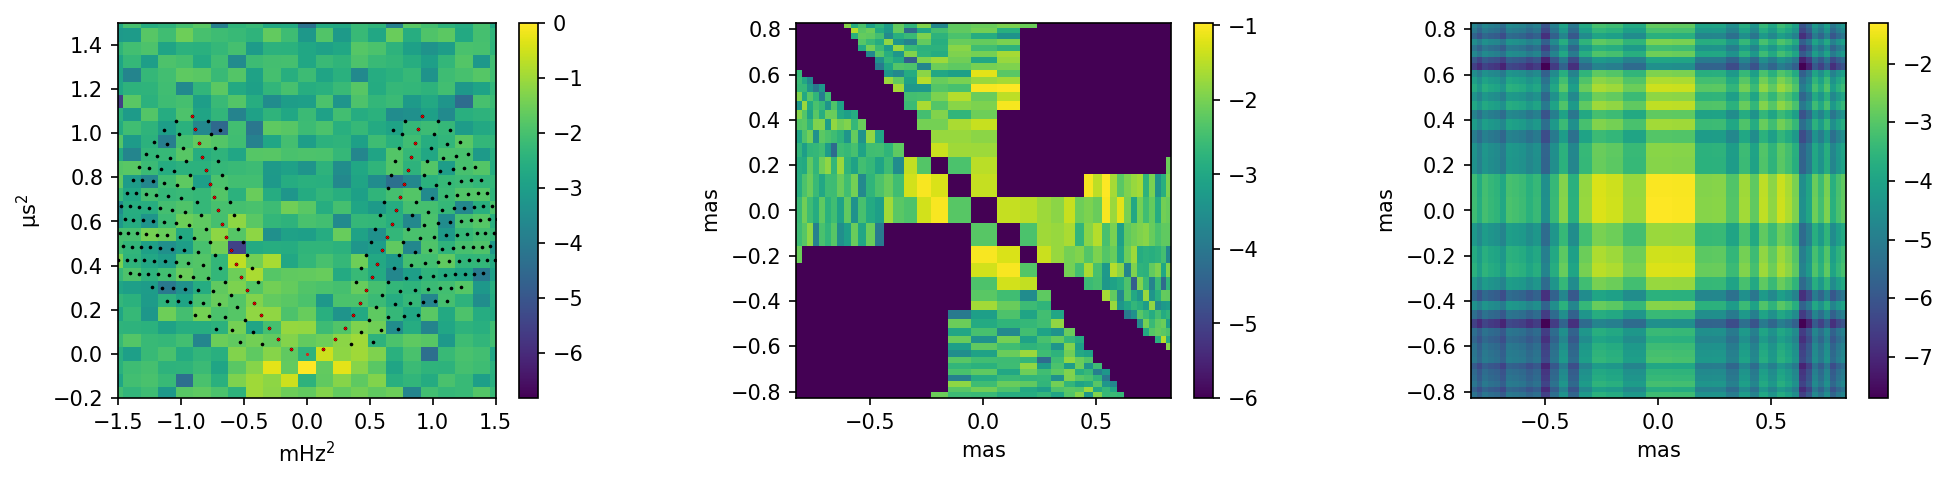

In [235]:
ds = DynamicSpectrum(dynspec, f=f, t=t, noise=None, d_eff=d_eff,
                     mu_eff=mu_eff, theta=th_r)

th_th = ds.theta_theta()



th_kwargs = dict(extent=(th_g[0].value, th_g[-1].value)*2,origin='lower')

th_th_proj = ThetaTheta(th_r)

fig=plt.figure(figsize=(9,2.5), dpi=150)
fig.add_axes([-0.5,0.0,0.35,1.0])
frame1=plt.gca()
plt.plot(fd_g[i0]-fd_g[i1], tau_g[i0]-tau_g[i1], 'ko', ms=0.75)
plt.plot(fd_g, tau_g, 'ro', ms=0.4)
sec_extent = (fd[0].value, fd[-1].value, tau[0].value, tau[-1].value)
plt.imshow(np.log10(ss.T), aspect='auto', extent=sec_extent,cmap='viridis')
plt.xlabel(fd.unit.to_string('latex'))
plt.ylabel(tau.unit.to_string('latex'))
plt.xlim(-1.5, 1.5)
plt.ylim(-0.2,1.5)
plt.colorbar()


fig.add_axes([0.0,0.0,0.35,1.0],projection=th_th_proj)
frame1=plt.gca()
plt.imshow(np.log10(np.maximum(np.abs(th_th)**2, 1e-30)), **th_kwargs, vmin=-6)
plt.colorbar()
plt.xlabel(th_g.unit.to_string('latex'))
plt.ylabel(th_g.unit.to_string('latex'))


#Calculate eigenvectors for inferred theta-theta.

w, v = scipy.linalg.eigh(th_th, eigvals=(th_g.size-1, th_g.size-1))

# Ideally, the eigenvalue is 1, but we want a normalized solution anyway,
# so just use properly normalized eigenvector.
recovered = v[:, -1]

fig.add_axes([0.5,0.0,0.35,1.0], projection=th_th_proj)
frame1=plt.gca()
# Show the theta-theta implied by largest eigenvector.
plt.imshow(np.log10(np.abs(np.outer(recovered, recovered.conj())**2)),
          **th_kwargs)
plt.colorbar()
plt.xlabel(th_g.unit.to_string('latex'))
plt.ylabel(th_g.unit.to_string('latex'))
plt.savefig('martens_thth_mapping.png',format='png', bbox_inches='tight',dpi=150)

In [ ]:
dynwave_r = dynamic_field(th_r, 0, recovered, d_eff, mu_eff, f, t)
dynspec_r = np.maximum(np.abs(dynwave_r.sum(0)) ** 2, 1e-30)

# Mean of dynamic spectra should equal sum of all recovered powers.
# Since we normalize that to (close to) 1, just rescale similarly here.
dynspec_r *= dynspec.mean()/dynspec_r.mean()
plt.imshow(dynspec_r.T, **ds_kwargs)
plt.xlabel(t.unit.to_string('latex'))
plt.ylabel(f.unit.to_string('latex'))
plt.colorbar()

In [ ]:
    def theta_grid(self, oversample_tau=1.3, oversample_fd=1.69, **kwargs):
        """Calculate a grid of theta for modelling the dynamic spectrum.
        Wraps `screens.fields.theta_grid` with defaults from the class.
        See that function for details.
        Note that this does *not* set the angles on the class, so typical
        usage is ``ds.theta = ds.theta_grid()``.
        """
        kwargs.setdefault('d_eff', self.d_eff)
        kwargs.setdefault('mu_eff', self.mu_eff)
        kwargs.setdefault('fobs', self.f.mean())
        kwargs.setdefault('dtau', (1./self.f.ptp()).to(u.us)
                          / oversample_tau)
        kwargs.setdefault('dfd', (1./self.t.ptp()).to(u.mHz)
                          / oversample_fd)
        kwargs.setdefault('tau_max', 1/np.abs(self.f[2]-self.f[0]).min())
        kwargs.setdefault('fd_max', 1/np.abs(self.t[2]-self.t[0]).min())
        return theta_grid(**kwargs)

    def dynamic_bases(self, mu_eff=None):
        """Calculate the amplitude infererence patterns for current fit.
        The power of the sum of these amplitudes is a dynamic spectrum.
        Explicitly assumes that time and frequency are the last two axes
        of the dynamic spectrum.  (TODO: lift this restriction.)
        Parameters
        ----------
        mu_eff : `~astropy.units.Quantity`, optional
            Effective proper motion to use.  Defaults to that stored on
            the instance.  Will *not* update the instance.
        Notes
        -----
        The calculated dynamic bases are cached for a given ``mu_eff``.
        """
        if mu_eff is None:
            mu_eff = self.mu_eff

        if mu_eff != getattr(self, '_mu_eff_old', None):
            self._dyn_wave = dynamic_field(
                self.theta, 0., 1.,
                self.d_eff, mu_eff, self.f, self.t).reshape(
                    (1,)*(self.dynspec.ndim-2)+(-1,)+self.dynspec.shape[-2:])
            self._mu_eff_old = mu_eff

        return self._dyn_wave

    def theta_theta(self, mu_eff=None, theta_grid=None, **kwargs):
        """Create a theta-theta array from the dynamic spectrum.
        For a given grid in ``theta`` (possibly calculated) and a set of pairs
        found using `screens.fields.theta_theta_indices`, this brute-force
        estimates the amplitudes at each pair by cross-multiplying their
        expected signature in the dynamic spectrum.
        Parameters
        ----------
        mu_eff : `~astropy.units.Quantity`, optional
            Effective proper motion to use.  Defaults to that stored on
            the instance.  Will update the instance if given.
        theta_grid : bool, optional
            Whether to calculate a new theta grid, or use the one stored
            on the instance.  By default, calculate it only if ``mu_eff`` is
            passed in.  If `True`, this will update the grid stored on the
            instance.
        **kwargs
            Any further arguments are passed on to
            `~screens.dynspec.DynamicSpectrum.theta_grid`
        """
        if mu_eff is not None:
            self.mu_eff = mu_eff

        if theta_grid or (theta_grid is None and mu_eff is not None):
            self.theta = self.theta_grid(**kwargs)
            self._mu_eff_old = None

        dynwave = self.dynamic_bases()
        # Get intensities by brute-force mapping:
        # dynspec * dynwave[j] * dynwave[i].conj() / sqrt(2) for all j > i
        # Do first product ahead of time to speed up calculation
        # (remove constant parts of input spectrum to eliminate edge effects)
        ddyn = dynwave * np.expand_dims(
            self.dynspec - self.dynspec.mean(), -3)
        # Explicit loop is faster than just broadcasting or using indices
        # for advanced indexing, since it avoids creating a large array.
        result = np.zeros(self.dynspec.shape[:-2] + self.theta.shape * 2,
                          ddyn.dtype)
        indices = theta_theta_indices(self.theta)
        for i, j in zip(*indices):
            amplitude = ((ddyn[..., j, :, :]
                          * dynwave[..., i, :, :].conj()).mean((-2, -1))
                         / np.sqrt(2.))
            result[..., i, j] = amplitude
            result[..., j, i] = amplitude.conj()

        return result

    def locate_mu_eff(self, mu_eff_trials=None, verbose=True, use=True,
                      **kwargs):
        """Try reproducing the dynamic spectrum for a range of proper motion.
        For each proper motion, construct a theta-theta array, calculte the
        largest eigenvalue and use the corresponding eigenvector as the model
        one-dimensional screen.
        Parameters
        ----------
        mu_eff_trials : `~astropy.units.Quantity`
            Proper motions to try.
        verbose : bool
            Whether or not to give summary statistics for each trial.
        use : bool
            Whether to store the best-fit proper motion and corresponding
            theta grid and magnifications on the instance.
        **kwargs
            Further parameters to use in calculating the theta grid for each
            proper motion.
        Returns
        -------
        curvature : `~astropy.table.QTable`
            Table with the following columns:
            - ``mu_eff`` : Input proper motions.
            - ``theta`` : grid in theta used.
            - ``w`` : Largest eigenvalue.
            - ``recovered`` : corresponding eigenvector, i.e., magnifications.
            - ``th_ms`` : Mean-square residual in theta-theta space.
            - ``ndof`` : degrees of freedom ``n_dynspec - n_theta - 2``.
            - ``redchi2`` : reduced chi2 ``((dynspec - model)/noise)**2/ndof``.
        Notes
        -----
        The resulting table is also stored on the instance, as ``curvature``.
        """
        if mu_eff_trials is None:
            mu_eff_trials = np.linspace(self.mu_eff * 0.8,
                                        self.mu_eff * 1.2, 21)
        r = QTable([mu_eff_trials], names=['mu_eff'])
        shape = (len(mu_eff_trials),) + self.dynspec.shape[:-2]
        r['theta'] = np.zeros(len(mu_eff_trials), object)
        r['w'] = np.zeros(shape)
        r['recovered'] = np.zeros(len(mu_eff_trials), object)
        r['th_ms'] = np.zeros(shape)
        r['ndof'] = 0
        r['redchi2'] = np.zeros(shape)
        for i, mu_eff in enumerate(r['mu_eff']):
            th_th = self.theta_theta(mu_eff, **kwargs)
            w, v = eigh(th_th)
            recovered = v[..., -1]
            recovered0 = recovered[..., self.theta == 0]

            recovered *= recovered0.conj()/np.abs(recovered0)

            th_ms = (np.abs(
                th_th - (recovered[..., :, np.newaxis]
                         * recovered[..., np.newaxis, :].conj()))**2).mean()
            dynspec_r = self.model(recovered, mu_eff=mu_eff)
            # Mean of dynamic spectra should equal sum of all recovered powers.
            # Since we normalize that to (close to) 1, just rescale similarly.
            dynspec_r *= (self.dynspec.mean((-2, -1), keepdims=True)
                          / dynspec_r.mean((-2, -1), keepdims=True))
            ndof = (self.dynspec.shape[-1] * self.dynspec.shape[-2]
                    - self.theta.size - 2)
            redchi2 = (((self.dynspec-dynspec_r)**2).sum((-2, -1))
                       / self.noise**2) / ndof
            r['theta'][i] = self.theta
            r['w'][i] = w[..., -1]
            r['recovered'][i] = recovered
            r['th_ms'][i] = th_ms
            r['ndof'][i] = ndof
            r['redchi2'][i] = redchi2
            if verbose:
                print(f'{mu_eff} {w[..., -1]} {ndof} {redchi2}')

        self.curvature = r
        if use:
            ibest = r['redchi2'].argmin(0)
            self.theta = r['theta'][ibest]
            self.magnification = np.array(r['recovered'][ibest])
            if self.dynspec.ndim > 2:
                assert self.dynspec.ndim == 3, 'not implemented yet'
                self.magnification = np.array(
                    [self.magnification[i][i]
                     for i in range(self.dynspec.shape[0])],
                    dtype=object)
            self.mu_eff = r['mu_eff'][ibest]

        return r

In [223]:
def expand(*arrays, n=2):
    """Add n unity axes to the end of all arrays."""
    result = [np.reshape(array, np.shape(array)+(1,)*n)
              for array in arrays]
    return result if len(arrays) > 1 else result[0]


In [232]:
f.ndim

1

In [ ]:
def dynamic_field(theta_par, theta_perp, realization, d_eff, mu_eff, f, t,
                  fast=True):
    """Given a set of scattering points, construct the dynamic wave field.

    Parameters
    ----------
    theta_par : ~astropy.units.Quantity
        Angles of the scattering point in the direction parallel to ``mu_eff``
    theta_perp : ~astropy.units.Quantity
        Angles perpendicular to ``mu_eff``.
    realization : array-like
        Complex amplitudes of the scattering points.  Set to ``1.`` to avoid
        using it.
    d_eff : ~astropy.units.Quantity
        Effective distance.  Should be constant; if different for
        different points, no screen-to-screen scattering is taken into
        account.
    mu_eff : ~astropy.units.Quantity
        Effective proper motion (``v_eff / d_eff``), i.e., parallel to
        ``theta_par``.
    t : ~astropy.units.Quantity
        Times for which the dynamic wave spectrum should be calculated.
        Should broadcast with ``f`` to give the dynamic spectrum shape.
    f : ~astropy.units.frequency
        Frequencies for which the spectrum should be calculated.
        Should broadcast with ``t`` to give the dynamic spectrum shape.
    fast : bool
        Calculates the field faster by iteratively applying a phasor for each
        the frequency step along the frequency axis. Assumes the frequencies
        are a linear sequence.  Will lead to inaccuracies at the 1e-9 level,
        which should be negligible for most purposes.

    Returns
    -------
    dynwave : array
        Delayed wave field array, with time and frequency axes as given by
        ``t`` and ``f``, and earlier axes as given by the other parameters.
    """
    ds_ndim = np.broadcast(f, t).ndim
    theta_par, theta_perp, realization, d_eff, mu_eff = expand(
        theta_par, theta_perp, realization, d_eff, mu_eff, n=ds_ndim)
    th_par = theta_par + mu_eff * t
    tau_t = (((d_eff / (2*const.c)) * (th_par**2 + theta_perp**2))
             .to(u.s, u.dimensionless_angles()))
    result = phasor(f, tau_t, linear_axis=(f.shape.index(f.size)-f.ndim if fast else None))
    if np.any(realization != 1.):
        result *= realization
    return result


In [ ]:
def phasor(indep, transform, linear_axis=None):
    """Calculate phase part of a Fourier transform like operation.

    Simply calcated ``exp(-j*indep*transform)``, where generally the two
    inputs will be on different dimensions, so that they broadcast against
    each other.  If the independent variable spans a linearly spaced range,
    one can use ``linear_axis`` to speed up the calculation by only calculating
    ``exp(-j*indep[0]*transform)`` and ``exp(-j*(indep[1]-indep[0])*tranform)``
    and filling the array by cumulative multiplication.

    Parameters
    ----------
    indep : array_like
        Independent variable.
    transform : array_like
        Transformed variable.  If an `~astropy.units.Quantity`, it must have
        the inverse units of ``indep``.  It should *not* include a factor 2pi.
    linear_axis : int, optional
        Possible axis along which ``indep`` changes by linear steps, and for
        which the calculation can be sped up using cumulative multiplication.
        This will lead to inaccuracies at the 1e-9 level, which should not
        matter for most purposes.
    """
    if linear_axis is None:
        phasor = -1j * (indep * transform * u.cycle).to_value(u.rad)
        phasor = np.exp(phasor, out=phasor)
    else:
        if linear_axis > 0:
            linear_axis -= indep.ndim
        extra_slice = (slice(None),) * (-1-linear_axis)
        ph0_index = (Ellipsis, slice(0, 1)) + extra_slice
        ph01_index = (Ellipsis, slice(0, 2)) + extra_slice
        dph0_index = (Ellipsis, slice(1, None)) + extra_slice
        ph0 = (indep[ph0_index] * transform * u.cycle).to_value(u.rad)
        dph = (np.diff(indep[ph01_index], axis=linear_axis)
               * transform * u.cycle).to_value(u.rad)
        phasor = np.empty(np.broadcast(indep, transform).shape, complex)
        phasor[ph0_index] = np.exp(-1j * ph0)
        phasor[dph0_index] = np.exp(-1j * dph)
        phasor = np.cumprod(phasor, out=phasor, axis=linear_axis)

    return phasor


In [ ]:

tau_max = (1./(f[3]-f[0])).to(u.us)
th_g = theta_grid(d_eff, mu_eff, fobs=fobs,
                  dtau=1/f.ptp(), tau_max=tau_max,
                  dfd=1/t.ptp(), fd_max=1*u.Hz)
fd_g = (d_eff/const.c*mu_eff*fobs*th_g).to(
    u.mHz, equivalencies=u.dimensionless_angles())
tau_g = (d_eff/(2*const.c)*th_g**2).to(
    u.us, equivalencies=u.dimensionless_angles())
i0, i1 = theta_theta_indices(th_g)
plt.plot(fd_g[i0]-fd_g[i1], tau_g[i0]-tau_g[i1], 'bo', ms=0.2)
plt.plot(fd_g, tau_g, 'ro', ms=0.4)
sec_extent = (fd[0].value, fd[-1].value, tau[0].value, tau[-1].value)
plt.imshow(np.log10(ss.T), origin=0, aspect='auto', extent=sec_extent,
           cmap='Greys', vmin=-7, vmax=0)
plt.xlabel(fd.unit.to_string('latex'))
plt.ylabel(tau.unit.to_string('latex'))
plt.colorbar()

In [ ]:
# Create a DynamicSpectrum just to use its `theta_theta` method.
ds = DynamicSpectrum(spec.I, f=spec.f, t=t, noise=None, d_eff=d_eff,
                     mu_eff=mu_eff, theta=th_r)

th_th = ds.theta_theta()
th_th_proj = ThetaTheta(th_r)
# Calculate eigenvectors for inferred theta-theta.

w, v = scipy.linalg.eigh(th_th, eigvals=(th_r.size-1, th_r.size-1))
recovered = v[:, -1]

# Show the theta-theta implied by largest eigenvector.
# As well as the corresponding dynamic spetrum.


dynwave_r = dynamic_field(th_r, 0, recovered, d_eff, mu_eff, spec.f, t)
dynspec_r = np.maximum(np.abs(dynwave_r.sum(0)) ** 2, 1e-30)
if plot_mds is True:
    vmin, vmax=np.percentile(dynspec_r, [1,99])
    plt.imshow(dynspec_r.T, aspect='auto', vmin=vmin, vmax=vmax, origin='lower')
    plt.show()
# Mean of dynamic spectra should equal sum of all recovered powers.
# Since we normalize that to (close to) 1, just rescale similarly here.
dynspec_r *= ds.dynspec.mean()/dynspec_r.mean()
N=np.std(ds.dynspec)
chi2=((ds.dynspec-dynspec_r)**2).mean()/N**2

return chi2